In [34]:
import numpy as np 
import matplotlib.pyplot as plt

In [35]:
class RandomAction:
    def __init__(self, n_states=1000, left_reward=-1):
        self.n_states = n_states
        self.left_reward = left_reward
        self.reset()

    def reset(self):
        self.state = self.n_states // 2
        return self.state

    def step(self):
        action = 0
        while action == 0:
            action = np.random.randint(-100, 101)

        self.state += action

        if self.state < 0:
            return self.state, self.left_reward, True
        elif self.state >= self.n_states:
            return self.state, 1, True
        return self.state, 0, False

In [36]:
def state_generalization(state):
    return state // 100

V = np.zeros(1000)
V_g = np.zeros(10)

episodes = 150000
alpha = 0.01
alpha2 = 0.001

In [37]:
env = RandomAction()

for episode in range(episodes):
    state = env.reset()
    done = False

    while not done:
        next_state, reward, done = env.step()
        if done:
            V[state] += alpha * (reward - V[state])
        else:
            V[state] += alpha * (reward + V[next_state] - V[state])

        state = next_state

In [38]:
env = RandomAction()

for episode in range(episodes):
    state = env.reset()
    state = state_generalization(state)
    done = False

    while not done:
        next_state, reward, done = env.step()
        next_state = state_generalization(next_state)
        if done:
            V_g[state] += alpha2 * (reward - V_g[state])
        else:
            V_g[state] += alpha2 * (reward + V_g[next_state] - V_g[state])

        state = next_state

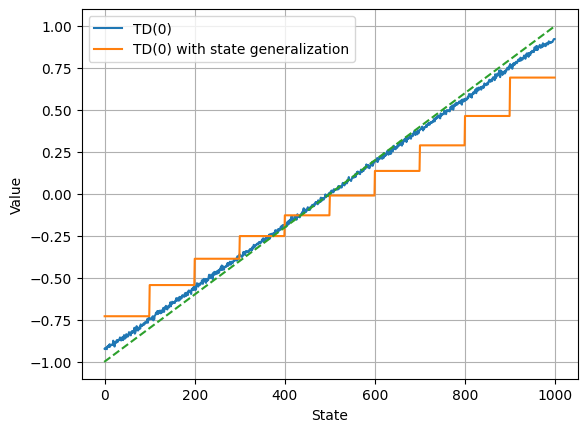

In [39]:
x = np.arange(0, 1000)
plt.plot(x, V, label='TD(0)')
plt.plot(x, V_g[state_generalization(x)], label='TD(0) with state generalization')
plt.plot([-1, 1000], [-1, 1], '--')
plt.legend()
plt.xlabel('State')
plt.ylabel('Value')
plt.grid()
plt.show()

In [156]:
class n_TD_generalization:
    def __init__(self, n, alpha, rd, do=False):
        self.alpha = alpha
        self.n = n
        self.V = np.zeros(20)
        self.gamma = 1
        if do:
            np.random.seed(rd)
            self.do()

    def state_generalization(self, state):
        return state // 50

    def do(self):
        env = RandomAction()

        episodes = 10

        for episode in range(episodes):
            states = []
            rewards = []
            state = env.reset()
            state = self.state_generalization(state)
            states.append(state)

            done = False

            t = 0
            T = float('inf')
            while True:
                if t < T:
                    state, reward, done = env.step()
                    state = self.state_generalization(state)
                    states.append(state)
                    rewards.append(reward)
                    if done:
                        T = t + 1
                tau = t - self.n + 1
                if tau >= 0:
                    G = sum([self.gamma ** (i-tau) * rewards[i] for i in range(tau, min(tau+self.n, T))])
                    if tau + self.n < T:
                        G += self.gamma ** self.n * self.V[states[tau + self.n]]
                    self.V[states[tau]] += self.alpha * (G - self.V[states[tau]])
                if tau == T - 1:
                    break
                t += 1

In [157]:
def RMS_RA(V_hat, V):
    V_hat = np.repeat(V_hat, 50)
    return np.sqrt(np.mean((V - V_hat) ** 2))

In [158]:
table = []

alphas = np.linspace(0, 1, 51)
n_s = [1, 2, 4, 8, 16, 32, 64]

for alpha in alphas:
    table_ = []
    for n in n_s:
        TDs = [n_TD_generalization(n, alpha, rd, do=True) for rd in range(20)]
        TD_RMS = [RMS_RA(td.V, V) for td in TDs]

        table_.append(np.mean(TD_RMS, axis=0))
    table.append(table_)

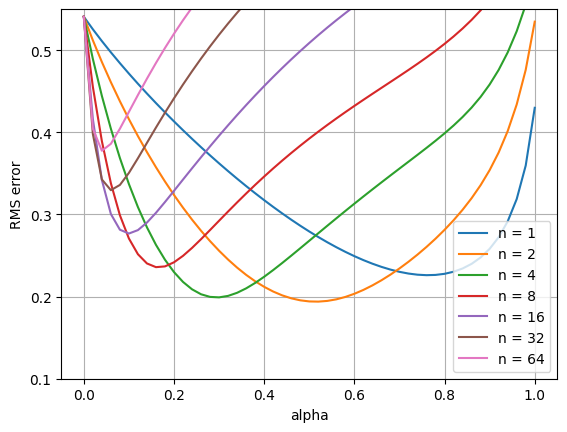

In [159]:
table = np.array(table)

for i in range(len(n_s)):
    plt.plot(alphas, table[:, i], label=f'n = {n_s[i]}')

plt.xlabel('alpha')
plt.ylabel('RMS error')
plt.legend()
plt.ylim([0.1, 0.55])
plt.grid()
plt.show()